In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize, signal, integrate, stats

from sklearn import metrics
from sklearn.linear_model import LinearRegression

## Inputs

In [2]:
T0 = 292.05           # K
p0 = 101600           # Pa
m = 2.7677            # g of Catalyst

In [3]:
R = 8.31446261815324  # J/mol.K
V = 190e-3            # L of Isopropanol
rho = 785             # g/L
M = 60.1              # g/mol
n0 = rho/M*V          # mol

In [4]:
sigma = 15            # s

In [5]:
data = pd.read_csv("data/cathet.csv")

## Dataset

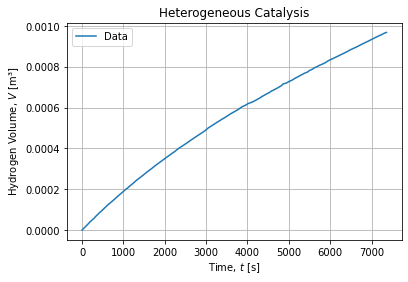

In [6]:
fig, axe = plt.subplots()
axe.plot(data["t"], data["V"], label="Data")
axe.set_title("Heterogeneous Catalysis")
axe.set_xlabel(r"Time, $t$ [s]")
axe.set_ylabel(r"Hydrogen Volume, $V$ [m³]")
axe.legend()
axe.grid()

## Model

In [7]:
def model(x, k1, k2):
    return (1/k1) * ((1 - k2)*x - k2*n0*np.log((n0 - x)/n0)) 

In [8]:
data["xi"] = p0*data["V"]/(R*T0)
data["st"] = sigma

In [9]:
popt, pcov = optimize.curve_fit(
    model, data["xi"].values, data["t"].values,
    sigma=data["st"].values, absolute_sigma=True
)

In [10]:
sk = np.sqrt(np.diag(pcov))

In [11]:
popt, sk

(array([9.03185361e-06, 7.80055898e+01]),
 array([2.09424662e-08, 5.39785853e-01]))

In [12]:
data["that"] = model(data["xi"].values, *popt)

In [13]:
R2 = metrics.r2_score(data["t"], data["that"])
R2

0.9999526276968933

In [14]:
nlls_integrated = {"k1": popt[0], "k2": popt[1], "R2": R2, "name": "NLLS Integrated"}

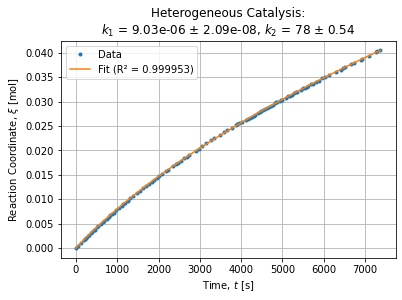

In [15]:
fig, axe = plt.subplots()
axe.plot(data["t"], data["xi"], label="Data", linestyle="none", marker=".")
axe.plot(data["that"], data["xi"], label="Fit (R² = {:.6f})".format(R2))
axe.set_title("Heterogeneous Catalysis:\n$k_1$ = {0:.3g} $\pm$ {2:.3g}, $k_2$ = {1:.3g} $\pm$ {3:.3g}".format(*popt, *sk))
axe.set_xlabel(r"Time, $t$ [s]")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ [mol]")
axe.legend()
axe.grid()

## Loss & Optimality

In [16]:
def factory(t, xi):
    @np.vectorize
    def wrapped(k1, k2):
        return np.log10(0.5*np.sum(np.power(t - model(xi, k1, k2), 2)))
    return wrapped

In [17]:
loss = factory(data["t"].values, data["xi"].values)

In [18]:
res = 400
k1lin = np.linspace(5e-6, 1.2e-5, res)
k2lin = np.linspace(70, 90, res)
K1, K2 = np.meshgrid(k1lin, k2lin)

In [19]:
MLE = loss(K1, K2)

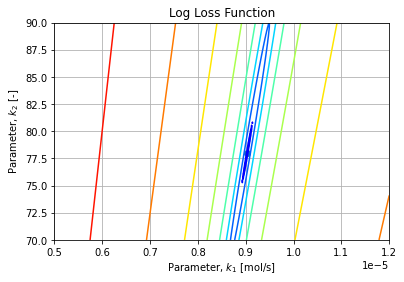

In [20]:
fig, axe = plt.subplots()
axe.contour(K1, K2, MLE, cmap="jet")
axe.scatter(*popt)
axe.set_title("Log Loss Function")
axe.set_xlabel("Parameter, $k_1$ [mol/s]")
axe.set_ylabel("Parameter, $k_2$ [-]")
#axe.set_xscale("log")
#axe.set_yscale("log")
axe.grid()

## Error Analysis

In [21]:
data["err"] = data["t"] - data["that"]

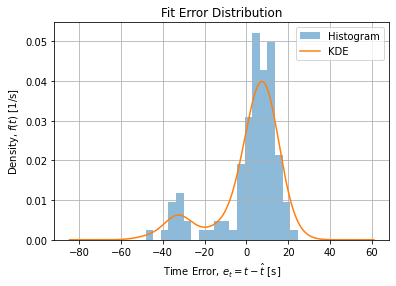

In [22]:
axe = data["err"].plot(kind="hist", bins=20, alpha=0.5, density=1., label="Histogram")
data["err"].plot(kind="kde", ax=axe, label="KDE")
axe.set_title("Fit Error Distribution")
axe.set_xlabel(r"Time Error, $e_t = t - \hat{t}$ [s]")
axe.set_ylabel(r"Density, $f(t)$ [1/s]")
axe.legend()
axe.grid()

## Goodness of Fit

In [23]:
data["chi2"] = data["err"]**2/sigma**2

In [24]:
n = data.shape[0]
chi2 = data["chi2"].sum()
chi2n = chi2 / n
chi2, chi2n

(113.78689215246058, 0.980921484072936)

In [25]:
alpha = 0.01

In [26]:
X = stats.chi2(df=n-1-2)

In [27]:
Xlin = np.linspace(0., max(n*1.5, chi2*1.5), 200)

In [28]:
chi2_c = X.ppf(1-alpha)
chi2_c

150.88215521838262

In [29]:
Xfill = np.linspace(chi2_c, Xlin.max(), 100)

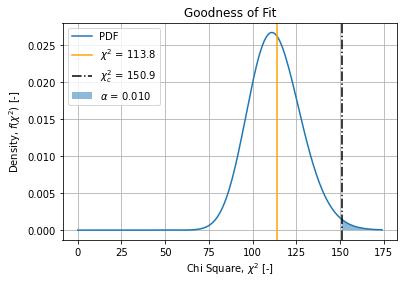

In [30]:
fig, axe = plt.subplots()
axe.plot(Xlin, X.pdf(Xlin), label="PDF")
axe.axvline(chi2, color="orange", label=r"$\chi^2$ = {:.1f}".format(chi2))
axe.axvline(chi2_c, linestyle="-.", color="black", label=r"$\chi^2_c$ = {:.1f}".format(chi2_c))
axe.fill_between(Xfill, X.pdf(Xfill), alpha=0.5, label=r"$\alpha$ = {:.3f}".format(alpha))
axe.set_title("Goodness of Fit")
axe.set_xlabel(r"Chi Square, $\chi^2$ [-]")
axe.set_ylabel(r"Density, $f(\chi^2)$ [-]")
axe.legend()
axe.grid()

## Checks

In [31]:
data["x1"] = data["xi"]/(n0 - data["xi"])
data["x2"] = np.log((n0 - data["xi"])/n0)

### OLS Integrated

In [32]:
def solve_integrated(X, y, name="OLS Integrated"):
    regressor = LinearRegression(fit_intercept=False)
    regressor.fit(X, y)
    R2 = regressor.score(X, y)
    c1, c2 = regressor.coef_
    k1 = n0/((n0*c1 - c2))
    k2 = -c2/(n0*c1 - c2)
    return {"c1": c1, "c2": c2, "k1": k1, "k2": k2, "R2": R2, "name": name, "regressor": regressor}

In [33]:
ols_integrated = solve_integrated(data[["xi", "x2"]].values, data["t"].values)

### Lineweaver-Bürk

In [34]:
def solve_lb(X, y, name):
    regressor = LinearRegression(fit_intercept=True)
    regressor.fit(X, y)
    s = regressor.score(X, y)
    c1 = regressor.intercept_
    c2 = regressor.coef_[0]
    k1 = 1/c1
    k2 = c2/c1
    return {"c1": c1, "c2": c2, "k1": k1, "k2": k2, "R2": s, "name": name, "regressor": regressor}

In [35]:
def plot_solve_lb(X, y, name):
    solution = solve_lb(X, y, name)
    fig, axe = plt.subplots()
    axe.plot(X, y, linestyle="none", marker=".", label="Data")
    axe.plot(X, solution["regressor"].predict(X), label="Fit")
    axe.set_title("Linearization: %s" % name)
    axe.set_xlabel(r"Product/Reactant Ratio, $\frac{\xi}{n_0 - \xi}$ [-]")
    axe.set_ylabel(r"Inverse Kinetic Rate, $\frac{1}{r}$ [s/mol]")
    axe.legend()
    axe.grid()
    return solution

#### First differences

In [36]:
data["r_DxiDt"] = data["xi"].diff()/data["t"].diff()

{'c1': 111937.8857912298,
 'c2': 8758594.37572878,
 'k1': 8.933525882962039e-06,
 'k2': 78.2451295539388,
 'R2': 0.5651210068499689,
 'name': 'OLS LB 1st Diff.',
 'regressor': LinearRegression()}

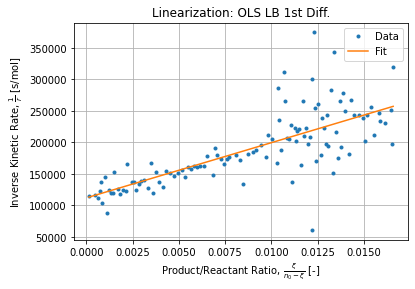

In [37]:
lb_DxiDt = plot_solve_lb(data.loc[1:, ["x1"]].values, 1./data.loc[1:, "r_DxiDt"].values, name="OLS LB 1st Diff.")
lb_DxiDt

#### Polynomial estimation

In [38]:
coefs = np.polyfit(data["t"], data["xi"], 3)
data["r_P3"] = np.polyval(np.polyder(coefs, m=1), data["t"])

{'c1': 113613.582466536,
 'c2': 8318864.345468159,
 'k1': 8.801764527533865e-06,
 'k2': 73.22068510530787,
 'R2': 0.9867005052472717,
 'name': 'OLS LB Poly 3',
 'regressor': LinearRegression()}

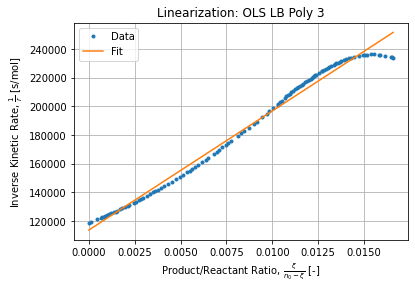

In [39]:
lb_P3 = plot_solve_lb(data[["x1"]].values, 1./data["r_P3"].values, name="OLS LB Poly 3")
lb_P3

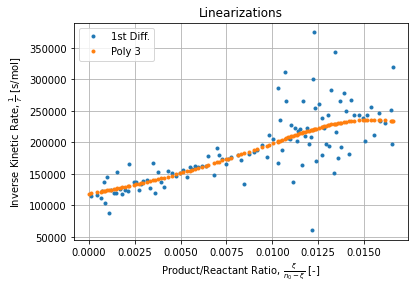

In [40]:
fig, axe = plt.subplots()
axe.plot(data["x1"], 1/data["r_DxiDt"], linestyle="none", marker=".", label="1st Diff.")
axe.plot(data["x1"], 1/data["r_P3"], linestyle="none", marker=".", label="Poly 3")
axe.set_title("Linearizations")
axe.set_xlabel(r"Product/Reactant Ratio, $\frac{\xi}{n_0 - \xi}$ [-]")
axe.set_ylabel(r"Inverse Kinetic Rate, $\frac{1}{r}$ [s/mol]")
axe.legend()
axe.grid()

## Summary

In [41]:
results = pd.DataFrame([
    nlls_integrated, ols_integrated,
    lb_DxiDt, lb_P3
])
results

,k1,k2,R2,name,c1,c2,regressor
0,0.000009,78.005590,0.999953,NLLS Integrated,NaN,NaN,NaN
1,0.000009,78.005591,0.999953,OLS Integrated,-8.526001e+06,-2.143372e+07,LinearRegression(fit_intercept=False)
2,0.000009,78.245130,0.565121,OLS LB 1st Diff.,1.119379e+05,8.758594e+06,LinearRegression()
3,0.000009,73.220685,0.986701,OLS LB Poly 3,1.136136e+05,8.318864e+06,LinearRegression()


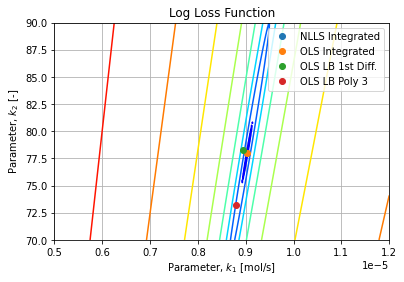

In [42]:
fig, axe = plt.subplots()
axe.contour(K1, K2, MLE, cmap="jet")
for index, row in results.iterrows():
    axe.plot([row["k1"]], [row["k2"]], linestyle="none", marker="o", label=row["name"])
axe.set_title("Log Loss Function")
axe.set_xlabel("Parameter, $k_1$ [mol/s]")
axe.set_ylabel("Parameter, $k_2$ [-]")
#axe.set_xscale("log")
#axe.set_yscale("log")
axe.legend()
axe.grid()